### REGRESIÓN LINEAL EN PYTHON Y VARIABLES PROXY

##### Para esta clase utilizaremos como referencia la hipótesis y datos utilizados en el artículo: **"The Colonial Origins of Comparative Development: An Empirical Investigation"**

* Autores: Daron Acemoglu, Simon Johnson, James A. Robinson

* Fuente: The American Economic Review, Vol. 91, No. 5 (Dec., 2001), pp. 1369-1401 https://economics.mit.edu/files/4123

* La versión en español la pueden encontrar en  redalyc.org/pdf/419/41901302.pdf

#### PROPÓSITO DE ESTA CLASE
* Aplicar el concepto de variables instrumentales que ya revisamos de forma teórica.
* Utilizando un modelo de 2 etapas analizar la hipótesis de los autores: el desempeño económico observado puede ser atribuido a las diferencias institucionales.

* **Los autores del artículo proponen 3 premisas:**

* 1. Los diversos tipos de políticas de colonización crearon diferentes grupos de instituciones.  En un extremo, los europeos establecieron “Estados extractivos” , instituciones que  no proporcionaron mucha protección a la propiedad privada, ni establecieron un sistema de pesos y contrapesos contra la  expropiación del gobierno. 

* En el otro extremo, muchos europeos emigraron y se asentaron en diversas colonias, creando  “nuevas Europas”. Los colonizadores trataron de replicar las instituciones europeas, con gran énfasis en la propiedad privada y en el control del poder del gobierno.

* 2. La factibilidad de los asentamientos influyó en la estrategia de colonización. En lugares donde el ambiente insalubre no era favorable al asentamiento europeo, no resultaba posible crear “nuevas Europas”,y era más factible la formación del Estado extractivo.

* 3. El Estado colonial y las instituciones persistieron aun después de la independencia.


* **HIPÓTESIS:** las tasas de mortalidad (potenciales) de los colonizadores fueron el principal determinante de los asentamientos; los asentamientos fueron un determinante importante de las instituciones iniciales (en la práctica, las instituciones de 1900); y existe una fuerte correlación entre las instituciones iniciales y las instituciones actuales.

**¿Cómo medimos las diferencias institucionales y los resultados económicos?**

* Los resultados económicos de una economía son aproximados por el logaritmo del PIB per cápita en 1995, ajustados por la paridad del poder adquisitivo, ppp.

* Las diferencias institucionales son aproximadas mediante el  índice de protección contra la expropiación que reporta un  valor entre 0 y 10 para cada país y año,donde 0 corresponde a la menor protección contra la expropiación. Se utilizó  el valor promedio de cada país entre 1985 y 1995 ( “riesgo de expropiación” promedio 1985-95", este índice fue construido por el Grupo de Servicios de Riesgo Político https://www.prsgroup.com/).

* La principal contribución del artículo es el uso de las tasas de mortalidad como fuente de variación exógena en las diferencias institucionales.

* Dicha variación es necesaria para determinar si son las instituciones las que dan lugar a un mayor crecimiento económico, y no al revés.



### 1.- Importando las librerías necesarias
* Para esta clase necesitamos instalar linearmodels

In [1]:
#!pip install pip
#!pip install <biblioteca>

In [1]:
import numpy as np
import pandas as pd
#pd.core.common.is_list_like = pd.api.types.is_list_like
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IVLIML, IV2SLS, IVLIML, IVGMM, IVGMMCUE
#
import warnings
warnings.filterwarnings('ignore')

### 2.-Descargando los datos.
* Con la ayuda de la instrucción *read_stata* leeremos los datos, nuestro Dataframe contiene la siguiente información:
- shortnam - Abreviatura Nonmbre país.
- euro1900 -Restricciones al Ejecutivo en 1900
- excolony: variable dummy 1- excolonia -0 no excolonia
- logpgp95 logaritmo del pib per cápita en 1995 
- avexpr 
  logaritmo de la tasa de mortalidad de los colonizadores para una muestra de 75 países,
- cons1 Constraint on executive in first year of independence 
-cons90 Constraint on executive in 1900 
-democ00a ïndice de democracia 1900
-cons00a
-extmort4
-logem4	Logaritmo del pib por trabajador, 1988
-loghjypl
-baseco




In [2]:
#
df1 = pd.read_stata('maketable1.dta')
df1.head()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
0,AFG,0.000000,1.0,NaN,NaN,1.0,2.0,1.0,1.0,93.699997,4.540098,NaN,NaN
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.- Explorando los datos de forma gráfica
* Con una gráfica de dispersión exploraremos la relación entre las variables **'avexpr' Protección promedio contra el riesgo de expropiación,1985-1995 y 'logpgp95' Logaritmo del pib per cápita, 1975 y 1995**.
* ¿Qué tipo de relación observas en los datos?

In [4]:
# NOTA:
# 
#print(plt.style.available)

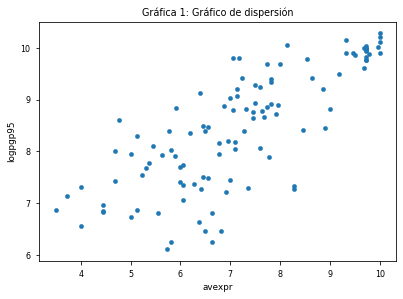

In [3]:
#
plt.style.use('seaborn-paper') #ggplot, seaborn-white, seaborn-paper, seaborn-poster
df1.plot(x ='avexpr', y ='logpgp95', kind = 'scatter')
plt.title('Gráfica 1: Gráfico de dispersión')
plt.show()

### 4.- Modelo OLS Bivariado

* Si un alto índice de  Protección promedio contra el riesgo de expropiación es una medida de calidad institucional, entonces **"mejores instituciones"  parecen estar positivamente correlacionadas con mejores desempeño económico (medido como un alto PIB per capita).**

* Para describir esta relación, podríamos generar un **modelo bivariado entre el PIB percápita como variable dependiente y el Índice de Protección  promedio contra el riesgo de expropiación  como variable explicativa.**

In [4]:
# Generamos un subconjunto limpio de datos eliminando las observaciones con datos NA
df1_subset = df1.dropna(subset = ['logpgp95', 'avexpr'])

df1_subset.head()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0
5,AUS,98.000000,1.0,9.318182,9.897972,7.0,7.0,10.0,7.0,8.550000,2.145931,-0.170788,1.0
6,AUT,100.000000,0.0,9.727273,9.974877,NaN,NaN,NaN,NaN,NaN,NaN,-0.343900,NaN


In [5]:
#
df1_subset = df1_subset[df1_subset['baseco'] == 1]

df1_subset.tail()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
153,USA,87.5,1.0,10.000000,10.215740,7.0,7.0,10.0,7.0,15.000000,2.708050,0.000000,1.0
155,VEN,20.0,1.0,7.136364,9.071078,1.0,3.0,1.0,3.0,78.099998,4.357990,-0.703197,1.0
156,VNM,0.0,1.0,6.409091,7.279319,1.0,3.0,0.0,1.0,140.000000,4.941642,NaN,1.0
159,ZAF,22.0,1.0,6.863636,8.885994,3.0,7.0,3.0,3.0,15.500000,2.740840,-1.386294,1.0
160,ZAR,8.0,1.0,3.500000,6.866933,1.0,1.0,0.0,1.0,240.000000,5.480639,-3.411248,1.0


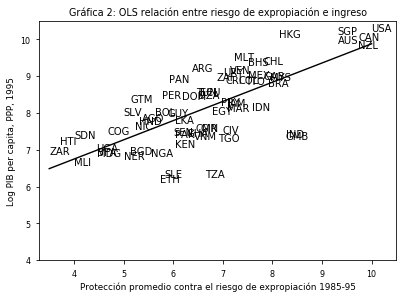

In [6]:
#Establecemos los parámetros X y Y
X = df1_subset['avexpr']
y = df1_subset['logpgp95']

#Guardamos los valores de nuestras etiquetas 
labels = df1_subset['shortnam']

# Reemplazamos los marcadores con los nombres de las etiquetas
fig, ax = plt.subplots()
ax.scatter(X, y, marker = '')

for i, label in enumerate(labels):
    ax.annotate(label, (X.iloc[i], y.iloc[i]))

# Trazamos una línea de tendencia
ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color = 'black')

ax.set_xlim([3.3,10.5])
ax.set_ylim([4,10.5])
ax.set_xlabel('Protección promedio contra el riesgo de expropiación 1985-95')
ax.set_ylabel('Log PIB per capita, PPP, 1995')
ax.set_title('Gráfica 2: OLS relación entre riesgo de expropiación e ingreso')

# Save the Figure
#plt.savefig("FIGURA.png", bbox_inches = 'tight')

plt.show()

* Para estimar los parámetros del modelo OLS, necesitamos añadir una columna con valor 1 

In [7]:
#
df1['const'] = 1

df1.head()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco,const
0,AFG,0.000000,1.0,NaN,NaN,1.0,2.0,1.0,1.0,93.699997,4.540098,NaN,NaN,1
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0,1
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0,1
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


* Ahora podemos construir el modelo OLS

In [8]:
#
reg1 = sm.OLS( endog = df1['logpgp95'], exog = df1[['const', 'avexpr']], \
       missing = 'drop')

results = reg1.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     171.4
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           4.16e-24
Time:                        08:28:16   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6261      0.301     15.391      0.0

### Resultados:
**intercepto=4.63, B1=0.53,** la calidad institucional tiene un efecto positivo  en el desempeño económico.
**p-value:** El efecto de las instituciones sobre el PIB per cápita  es estadísticamente significativo
**R²=.611** al rededor de 61% de la variación en la variable LOG PIB per cápita es explicada por la variable Índice de  Protección promedio contra el riesgo de expropiación

### Utilizando nuestro modelo para predecir niveles de PIB per cápita

In [9]:
#primero calculamos el promedio de avexpr

mean_expr = np.mean(df1_subset['avexpr'])

mean_expr

6.515625

In [10]:
results.predict(exog = [1, mean_expr] )

array([8.09156367])

### Podemos obtener el valor predicho para cada valor 

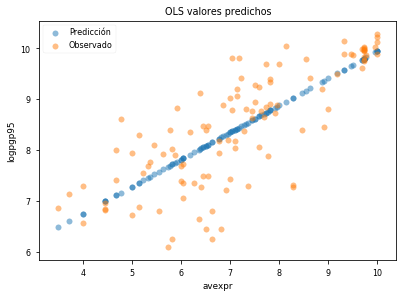

In [11]:
# Eliminamos los valores nulos de la base

df1_plot = df1.dropna( subset = ['logpgp95', 'avexpr'] )

# Graficamos los valores predichos

fix, ax = plt.subplots()
ax.scatter( df1_plot['avexpr'], 
            results.predict(), 
            alpha = 0.5,
            label = 'Predicción' )

# Graficamos los valores observados

ax.scatter( df1_plot['avexpr'], 
            df1_plot['logpgp95'], 
            alpha = 0.5, 
            label = 'Observado')

ax.legend()
ax.set_title( 'OLS valores predichos' )
ax.set_xlabel( 'avexpr' )
ax.set_ylabel( 'logpgp95' )

plt.show()

###  5.-Modelo Multivariado
* Hasta ahora, nuestro modelo sólo considera como variable explicativa el Índice de  Protección promedio contra el riesgo de expropiación, seguramente existen otras variables que tienen un efecto sobre el PIB per cápita.

* Los cálculos de los parámetros de nuestro modelo pueden estar afectados por lo que se conoce como **"sesgo de variable omitida"**, para solucionar este problema, extenderemos nuestro modelo para incluir otras variables.


In [12]:
#cargamos los datos para nuestro modelo multivariado

df2 = pd.read_stata('maketable2.dta')

# Creamos nuestra constante
df2['const'] = 1

df2

,shortnam,africa,lat_abst,avexpr,logpgp95,other,asia,loghjypl,baseco,const
0,AFG,0.0,0.366667,NaN,NaN,0.0,1.0,NaN,NaN,1
1,AGO,1.0,0.136667,5.363636,7.770645,0.0,0.0,-3.411248,1.0,1
2,ARE,0.0,0.266667,7.181818,9.804219,0.0,1.0,NaN,NaN,1
3,ARG,0.0,0.377778,6.386364,9.133459,0.0,0.0,-0.872274,1.0,1
4,ARM,0.0,0.444444,NaN,7.682482,0.0,1.0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...
158,YUG,0.0,0.488889,6.318182,NaN,0.0,0.0,-1.203973,NaN,1
159,ZAF,1.0,0.322222,6.863636,8.885994,0.0,0.0,-1.386294,1.0,1
160,ZAR,1.0,0.000000,3.500000,6.866933,0.0,0.0,-3.411248,1.0,1
161,ZMB,1.0,0.166667,6.636364,6.813445,0.0,0.0,-2.975930,NaN,1


In [13]:
# Creamos una lista de variables que serán utilizadas en cada regresión (vamos a generar 3 modelos) 
# Seleccionamos columnas mediante estas 3 listas:
X1 = ['const', 'avexpr']
X2 = ['const', 'avexpr', 'lat_abst']
X3 = ['const', 'avexpr', 'lat_abst', 'asia', 'africa', 'other']

# Estimaremos un modelo de regresión OLS por cada conjunto de variables.

reg1 = sm.OLS( df2['logpgp95'], df2[X1], missing = 'drop').fit()
reg2 = sm.OLS( df2['logpgp95'], df2[X2], missing = 'drop').fit()
reg3 = sm.OLS( df2['logpgp95'], df2[X3], missing = 'drop').fit() 

* Con la instrucción **summary_col** vamos a desplegar los resultados de los tres modelos en una sola tabla

In [14]:
#
info_dict = { 'R-squared' : lambda x: f"{x.rsquared:.2f}",
              'No. observations' : lambda x: f"{int(x.nobs):d}" }

results_table = summary_col( results = [reg1, reg2, reg3] ,
                             float_format = '%0.2f',
                             stars = True,
                             model_names = [ 'Model 1',
                                             'Model 3',
                                             'Model 4'],
                             info_dict = info_dict,
                             regressor_order = [ 'const',
                                                 'avexpr',
                                                 'lat_abst',
                                                 'asia',
                                                 'africa' ])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

        Table 2 - OLS Regressions
                 Model 1 Model 3 Model 4 
-----------------------------------------
R-squared        0.61    0.62    0.72    
R-squared Adj.   0.61    0.62    0.70    
africa                           -0.92***
                                 (0.17)  
asia                             -0.15   
                                 (0.15)  
avexpr           0.53*** 0.46*** 0.39*** 
                 (0.04)  (0.06)  (0.05)  
const            4.63*** 4.87*** 5.85*** 
                 (0.30)  (0.33)  (0.34)  
lat_abst                 0.87*   0.33    
                         (0.49)  (0.45)  
other                            0.30    
                                 (0.37)  
R-squared        0.61    0.62    0.72    
No. observations 111     111     111     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


### 6. Endogeneidad Modelo de Mínimos Cuadrados en dos etapas
* **Endogeneidad** puede surgir como resultado de un error de medición, autorregresión con autocorrelación de errores, simultaneidad y variables omitidas. Utilizando un modelo OLS de dos etapas revisaremos cómo podemos arreglar este problema.

* La relación que existe entre el Índice de protección  promedio contra el riesgo de expropiación ('avexpr') y el    Logaritmo del PIB per cápita, puede ser bidireccional. 
* Por ejemplo, es probable que los países más ricos puedan financiar o preferir mejores instituciones; o que las variables que afectan el ingreso también pueden estar correlacionadas con diferencias institucionales; también podría se plausible que  la construcción del índice de protección  promedio contra el riesgo de expropiación pudo sesgarse,  los analistas pueden estar predispuestos a ver que los países con mayores ingresos tengan mejores instituciones

### Instrumentos y Método de Variables Intrumentales en dos etapas

* Instrimentemos nuestro índice de protección a la democracia a través de una variable instrumental: la tasa de mortalidad de los primeros colonizadores.

* De esta forma utilizaremos el procedimiento de estimación de Mínimos Cuadros en Dos Etapas. Podemos utilizar el estimador de Variables Instrumentales para determinar (Segunda Etapa):

$$\hat{\boldsymbol{\beta}}^{IV} = (\hat{\mathbf{X}}' \mathbf{X})^{-1} \hat{\mathbf{X}}' \mathbf{Y}$$

* Por otro lado, podemoos establecer el siguiente vector de innstrumentos:
\begin{equation*}
    \mathbf{z}_i = (1, x_{i1}, \ldots, x_{iK-1}, z_{i1}, \ldots, z_{iM})
\end{equation*}

* Contruyendo de forma simimar a otras matrices a $\mathbf{Z}$ apilado la información de cada uno de los individuos. De esta forma podremos constriuir $\hat{\mathbf{X}}$ mediante el uso de un estimador de MCO:
\begin{eqnarray*}
    \hat{\mathbf{X}} & = & \mathbf{Z} \hat{\boldsymbol{\gamma}} \\
    & = & \mathbf{Z} (\mathbf{Z}' \mathbf{Z})^{-1} \mathbf{Z}' \mathbf{X}
\end{eqnarray*}

* De lo anterior tendríamos que (Primera Etapa):
\begin{equation*}
    \hat{\mathbf{X}}' = \mathbf{X}' \mathbf{Z} (\mathbf{Z}' \mathbf{Z})^{-1} \mathbf{Z}'
\end{equation*}

* Sólo para poner en contexto, podemos platear el Método Generalizado de Momentos de la siguiente forma:


$$\hat{\boldsymbol{\beta}}^{GMM} = (\hat{\mathbf{X}}' \hat{\mathbf{W}} \mathbf{X})^{-1} \hat{\mathbf{X}}'\hat{\mathbf{W}} \mathbf{Y}$$

Donde $\hat{\mathbf{W}}$ es una matriz definida positiva.

In [15]:
# Regresamos a nuestro DF inicial: Borrado de NA's 
df1_subset2 = df1.dropna(subset=['logem4', 'avexpr'])

X = df1_subset2['logem4']
y = df1_subset2['avexpr']
labels = df1_subset2['shortnam']

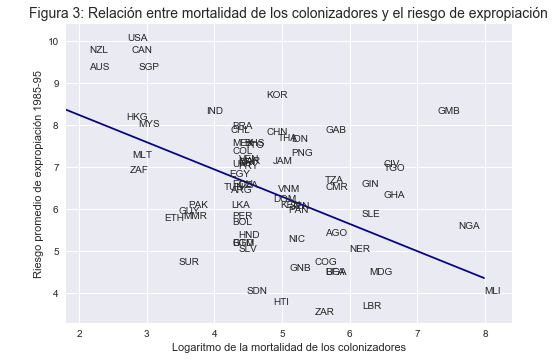

In [16]:
plt.style.use('seaborn')

# 
fig, ax = plt.subplots()
ax.scatter(X, y, marker = '')

for i, label in enumerate(labels):
    ax.annotate(label, (X.iloc[i], y.iloc[i]))

# Línea de tendencia
ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color = 'darkblue')

ax.set_xlim([1.8,8.4])
ax.set_ylim([3.3,10.4])
ax.set_xlabel('Logaritmo de la mortalidad de los colonizadores')
ax.set_ylabel('Riesgo promedio de expropiación 1985-95')
ax.set_title('Figura 3: Relación entre mortalidad de los colonizadores y el riesgo de expropiación'
            , size = 14)

#
plt.show()

### Primera Etapa: Para la primera etapa requerimos instrumentar el riesgo de expropiación

$$avexpr_i = \delta_0 + \delta_1 logem4_i + \nu_i$$

In [17]:
# Import and select the data
df4 = pd.read_stata('maketable4.dta')
df4 = df4[df4['baseco'] == 1]
df4.head()

,shortnam,africa,lat_abst,rich4,avexpr,logpgp95,logem4,asia,loghjypl,baseco
1,AGO,1.0,0.136667,0.0,5.363636,7.770645,5.634789,0.0,-3.411248,1.0
3,ARG,0.0,0.377778,0.0,6.386364,9.133459,4.232656,0.0,-0.872274,1.0
5,AUS,0.0,0.300000,1.0,9.318182,9.897972,2.145931,0.0,-0.170788,1.0
11,BFA,1.0,0.144444,0.0,4.454545,6.845880,5.634789,0.0,-3.540459,1.0
12,BGD,0.0,0.266667,0.0,5.136364,6.877296,4.268438,1.0,-2.063568,1.0


In [18]:
# 
df4['const'] = 1

# Regresión
results_fs = sm.OLS(df4['avexpr'],
                    df4[['const', 'logem4']],
                    missing='drop').fit()
print(results_fs.summary())

                            OLS Regression Results                            
Dep. Variable:                 avexpr   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     22.95
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           1.08e-05
Time:                        08:45:19   Log-Likelihood:                -104.83
No. Observations:                  64   AIC:                             213.7
Df Residuals:                      62   BIC:                             218.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3414      0.611     15.296      0.0

### Segunda Etapa: En la segunda etapa estimamos la ecuación de interés

$$logpgp95_i = β_0 + β_1 \widehat{avexpr}_i + \varepsilon_i$$

In [19]:
# Tomamos el valor predicho de la Primera Etapa:
df4['predicted_avexpr'] = results_fs.predict()

df4.head()

,shortnam,africa,lat_abst,rich4,avexpr,logpgp95,logem4,asia,loghjypl,baseco,const,predicted_avexpr
1,AGO,1.0,0.136667,0.0,5.363636,7.770645,5.634789,0.0,-3.411248,1.0,1,5.922342
3,ARG,0.0,0.377778,0.0,6.386364,9.133459,4.232656,0.0,-0.872274,1.0,1,6.773127
5,AUS,0.0,0.300000,1.0,9.318182,9.897972,2.145931,0.0,-0.170788,1.0,1,8.039306
11,BFA,1.0,0.144444,0.0,4.454545,6.845880,5.634789,0.0,-3.540459,1.0,1,5.922342
12,BGD,0.0,0.266667,0.0,5.136364,6.877296,4.268438,1.0,-2.063568,1.0,1,6.751415


In [20]:
# Estimamos la Segunda Etapa, mediante la estimación de la ecuación de interés
results_ss = sm.OLS(df4['logpgp95'],
                    df4[['const', 'predicted_avexpr']]).fit()
print(results_ss.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     56.60
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           2.66e-10
Time:                        08:47:54   Log-Likelihood:                -72.268
No. Observations:                  64   AIC:                             148.5
Df Residuals:                      62   BIC:                             152.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9097      0.823  

### Estimación en una sola instrucción: IV2SLS

In [21]:
# Sin estimación de ajuste de errores
iv = IV2SLS( dependent = df4['logpgp95'],
             exog = df4['const'],
             endog = df4['avexpr'],
             instruments = df4[['logem4']]).fit()#.cov_type='unadjusted')

print(iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               logpgp95   R-squared:                      0.1870
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1739
No. Observations:                  64   F-statistic:                    28.754
Date:                Mon, Mar 14 2022   P-value (F-stat)                0.0000
Time:                        08:51:27   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          1.9097     1.1740     1.6267     0.1038     -0.3912      4.2106
avexpr         0.9443     0.1761     5.3623     0.00